<a href="https://colab.research.google.com/github/tieukhoimai/binary-signal-recovery/blob/main/binary_signal_recovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/vrn/probability

/content/drive/MyDrive/vrn/probability


## Generate data

1. A random sensing matrix with i.i.d. entries sampled from $\mathcal{N}(0, 1)$, $\mathbf{X} \in \mathbb{R}^{m \times d}$

2. $\boldsymbol{\xi} \in \mathbb{R}^{m}$ be a noise vector, independent of $\mathbf{X}$, with i.i.d. entries sampled from $\mathcal{N}(0, 1)$.
3. $\Theta = \{0, 1\}^{d}$ (signal space) and $\boldsymbol{\theta} \in \Theta$ (signal) be chosen uniformly at random and be independent of the pair $(\mathbf{X}, \boldsymbol{\xi})$.
4. Measurement vector $\mathbf{y} \in \mathbb{R}^{m}$

$$\mathbf{y} = \mathbf{X}\boldsymbol{\theta} + \boldsymbol{\xi}$$

In [4]:
def generate_data(m, d):
  X = np.random.randn(m, d)  # Sensing matrix
  xi = np.random.randn(m)   # Noise
  theta = np.random.randint(2, size=d)  # Signal
  y = X @ theta + xi  # Measurements
  return X, y, theta

## Define the likelihood and energy functions

The maximum likelihood estimate of $\boldsymbol{\theta}$ is given by the value $\widehat{\boldsymbol{\theta}} \in \Theta$ that minimizes the function

$$H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}) = -(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})^{\top}(\mathbf{y} - \mathbf{X}\boldsymbol{\theta})$$

given the observations $(\mathbf{X}, \mathbf{y})$.

In [5]:
def H(X, y, theta):
  return (y - X @ theta).T @ (y - X @ theta)

## Metropolis-Hastings algorithm

1. Set $\boldsymbol{\theta}_0 = \bar{\boldsymbol{\theta}}$.
2. For $t = 1, 2, \ldots, N - 1$:
   1. Pick $i$ uniformly at random in $\{1, 2, \ldots, d\}$.
   2. Let the proposed state be $\boldsymbol{\theta}^* \in \Theta$, with entries
      $\boldsymbol{\theta}^*(j) = \begin{cases}
          \boldsymbol{\theta}^{t-1}(j) & \text{if } j \neq i \\
          1 - \boldsymbol{\theta}^{t-1}(j) & \text{if } j = i
      \end{cases} \text{ for } j = 1, 2, \ldots, d.$
   3. Set
      $\boldsymbol{\theta}^t = \begin{cases}
          \boldsymbol{\theta}^* & \text{with probability } \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\} \\
          \boldsymbol{\theta}^{t-1} & \text{with probability } 1 - \min\left\{1, \frac{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^*)\}}{\exp\{-\beta H(\mathbf{X}, \mathbf{y}; \boldsymbol{\theta}^{t-1})\}}\right\}
      \end{cases}.
      $

In [6]:
def metropolis_hastings(X, y, beta, M, initial_theta):
  d = len(initial_theta)
  theta = initial_theta.copy()

  for _ in range(M):
    i = np.random.randint(d)
    theta_star = theta.copy()
    theta_star[i] = 1 - theta_star[i]

    acceptance_prob = min(1, np.exp(-beta * (H(X, y, theta_star) - H(X, y, theta))))

    if np.random.rand() < acceptance_prob:
      theta = theta_star

  return theta

## Experimental

In [ ]:
def experiment(d=10, m_max=15, N=100, M=100, beta=1.0):
  start_time = time.time()
  ms = range(1, m_max + 1)
  MSEs = []

  for m in ms:
      mse = 0
      for _ in range(N):
          X, y, theta_true = generate_data(m, d)
          initial_theta = np.random.randint(2, size=d)
          theta_hat = metropolis_hastings(X, y, beta, M, initial_theta)
          mse += ((theta_hat - theta_true).T @ (theta_hat - theta_true)) / M
      MSEs.append(mse)

  end_time = time.time()
  avg_time = (end_time - start_time)

  return ms, MSEs, avg_time, N, M, beta

### Experiment with different values of $\beta$

In [ ]:
# Create an empty list to store the results
results = []

# Loop through the beta values
beta_values = np.linspace(0.1, 2.0, 5)

for beta_i in beta_values:
  ms, MSEs, avg_time, N, M, beta = experiment(d=10, m_max=15, N=1000, M=1000, beta=beta_i)

  # Store the results in the list
  results.append({
        'M': M,
        'N': N,
        'beta': beta,
        'm': list(ms),
        'MSE': MSEs,
        'Time': avg_time
    })

# Create a pandas DataFrame from the results list
df = pd.DataFrame(results)

In [ ]:
df

,M,N,beta,m,MSE,Time
0,1000,1000,0.100,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.883999999999949, 4.727999999999953, 4.45599...",333.190022
1,1000,1000,0.575,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.666999999999954, 4.306999999999962, 3.97299...",322.509038
2,1000,1000,1.050,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.489999999999955, 4.208999999999962, 3.85699...",324.471149
3,1000,1000,1.525,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.633999999999948, 4.13599999999996, 3.660999...",323.133945
4,1000,1000,2.000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.5249999999999595, 4.12299999999996, 3.64599...",321.659560


In [ ]:
df.to_csv('beta_exp.csv',index=False)

In [ ]:
df = pd.read_csv('beta_exp.csv')
df

,M,N,beta,m,MSE,Time
0,1000,1000,0.100,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.883999999999949, 4.727999999999953, 4.45599...",333.190022
1,1000,1000,0.575,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.666999999999954, 4.306999999999962, 3.97299...",322.509038
2,1000,1000,1.050,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.489999999999955, 4.208999999999962, 3.85699...",324.471149
3,1000,1000,1.525,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.633999999999948, 4.13599999999996, 3.660999...",323.133945
4,1000,1000,2.000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.5249999999999595, 4.12299999999996, 3.64599...",321.659560


In [7]:
def convert_str_to_arr(str_value):
  return [float(x.strip()) for x in str_value.strip('[]').split(',')]

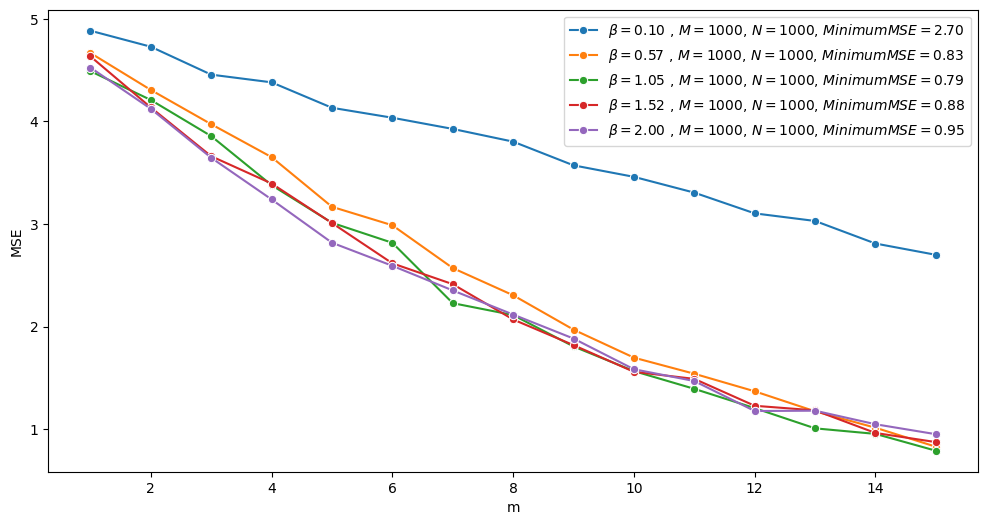

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(0,len(df)):
  m = convert_str_to_arr(df['m'][i])
  mse = convert_str_to_arr(df['MSE'][i])
  label = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df['beta'][i], df['M'][i], df['N'][i], min(mse))
  sns.lineplot(x=m, y=mse, marker='o',label=label)

ax.set_xlabel('m')
ax.set_ylabel('MSE')
# ax.grid(True)
# ax.legend(loc='center bottom', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

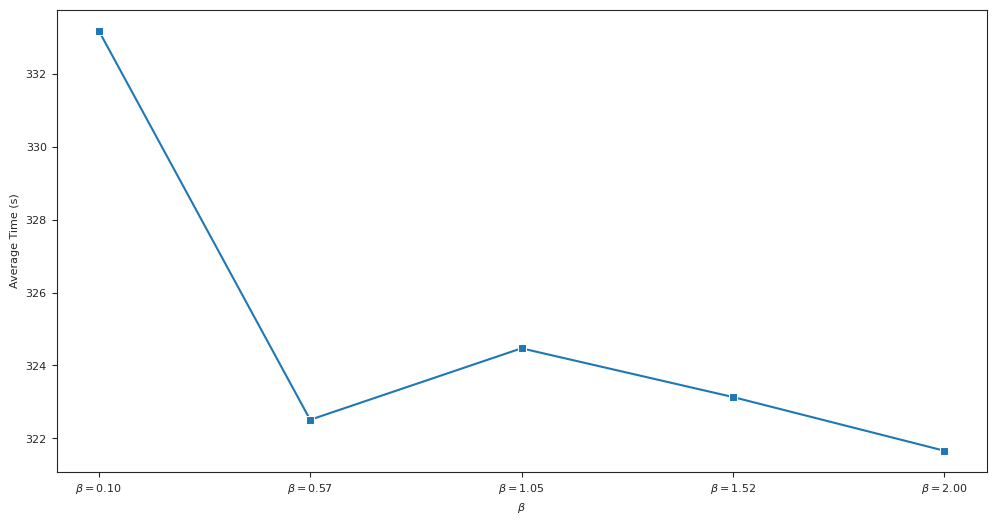

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df, x='beta', y='Time', marker='s')
ax.set_xticks(beta_values)
ax.set_xticklabels([r'$\beta = {:.2f}$'.format(beta) for beta in beta_values])
ax.set_xlabel(r'$\beta$')
ax.set_ylabel("Average Time (s)")
ax.grid(False)

## Experiment with different values of $M$

In [ ]:
# Create an empty list to store the results
m_results = []

# Loop through the beta values
M_values = np.linspace(1000, 10000, 5, dtype=int)

for M_i in M_values:
  ms, MSEs, avg_time, N, M, beta = experiment(d=10, m_max=15, N=1000, M=M_i, beta=1.0)

  # Store the results in the list
  m_results.append({
        'M': M,
        'N': N,
        'beta': beta,
        'm': list(ms),
        'MSE': MSEs,
        'Time': avg_time
    })

# Create a pandas DataFrame from the results list
df_m = pd.DataFrame(m_results)

In [ ]:
df_m

,M,N,beta,m,MSE,Time
0,1000,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[4.578999999999954, 4.180999999999963, 3.86099...",426.575558
1,3250,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.414461538461537, 1.2969230769230722, 1.1624...",1381.337108
2,5500,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.8281818181818139, 0.7836363636363586, 0.694...",2338.323926
3,7750,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.5943225806451659, 0.5424516129032306, 0.491...",3268.711053
4,10000,1000,1.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.46540000000000026, 0.42350000000000065, 0.3...",4431.456508


In [ ]:
df_m.to_csv('/content/drive/MyDrive/vrn/probability/m_exp.csv',index=False)

In [9]:
df_m = pd.read_csv('/content/drive/MyDrive/vrn/probability/m_exp.csv')

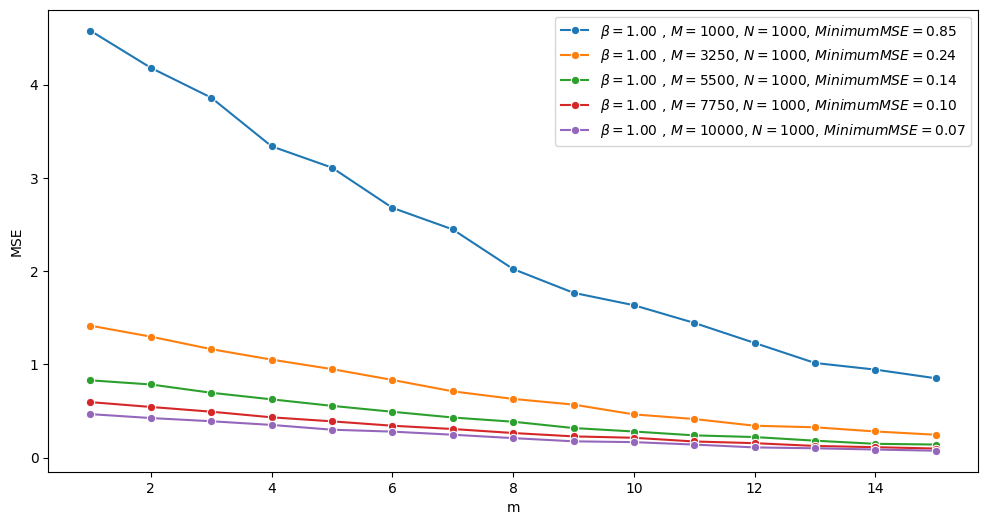

In [ ]:
ms = range(1, 16)

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(0,len(df)):
  label = r'$\beta = {0:.2f}$ , $M = {1:.0f}$, $N = {2:.0f}$, $Minimum MSE = {3:.2f}$'.format(df_m['beta'][i], df_m['M'][i], df_m['N'][i], min(df_m['MSE'][i]))
  sns.lineplot(x=df_m['m'][i], y=df_m['MSE'][i], marker='o',label=label)

ax.set_xlabel('m')
ax.set_ylabel('MSE')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.show()

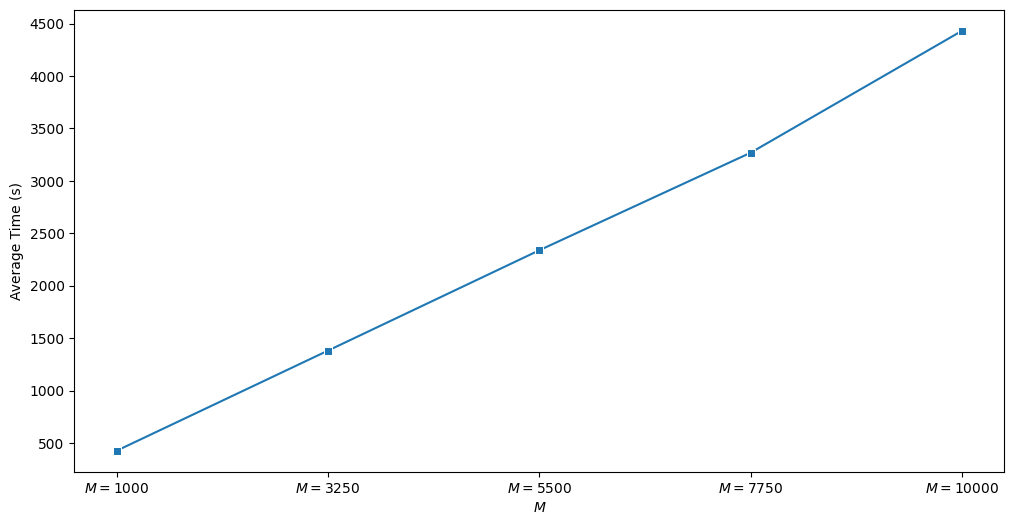

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.lineplot(data=df_m, x='M', y='Time', marker='s')
ax.set_xticks(M_values)
ax.set_xticklabels([r'$M = {}$'.format(str(M)) for M in M_values])
ax.set_xlabel(r'$M$')
ax.set_ylabel("Average Time (s)")
ax.grid(False)